<a href="https://colab.research.google.com/github/arkothiwala/QuoraQuestionPairs/blob/master/QQP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/kaggle.json #Need to upload kaggle.json file from C:\Users\<USERNAME>\.kaggle\

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Download Competition Data

In [0]:
# Downloading Data
!kaggle competitions download -c quora-question-pairs
# Extracting the data
import zipfile
zip_ref = zipfile.ZipFile('train.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()
zip_ref = zipfile.ZipFile('test.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

### Download GloVe Embeddings

In [0]:
# Lets Download GloVe Embeddings
import os
import urllib.request
urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.840B.300d.zip', 'glove840B.zip')

# Unzip the Embeddings
import zipfile
zip_ref = zipfile.ZipFile('glove840B.zip', 'r')
zip_ref.extractall('embeddings')
zip_ref.close()

glove = './embeddings/glove.840B.300d.txt'

### Load Embeddings

In [0]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index
embed_glove = load_embed(glove)

In [15]:
# Kaggle Stuff
!pip install kaggle
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
print(results)
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
print(kaggle_api_key)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

{'files': []}
[]


IndexError: ignored

In [0]:
?import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

#%%capture
from tqdm import tqdm_notebook as tqdm
#tqdm().pandas()

In [0]:
train_df = pd.read_csv('train.csv').dropna()
#test_df = pd.read_csv('../input/test.csv').dropna()
q1 = train_df.question1

## 1 Text Pre-processing

### 1.1. Put sentence between Start Stop Token

In [0]:
def addStartStopTokens(series):
    return '<start> ' + series.str.lower() + ' <stop>'

### 1.2. replace numbers with "number"

In [0]:
def replaceNumbers(series):
    # Space around number is added to ensure that
    # number was a single entity and not with a word (e.g. F1 visa, Audi A4)
    total = series.str.contains(' [\d]+ ').sum()
    print("{:.2f} % queries with numbers were processed".format(total*100/len(series)))
    return series.str.replace(' [+-]?([0-9]*[.])?[0-9]+ ',' number ')#.replace(' [\d]+(.[\d]+) ',' number ') # Still misses case of float numbers

### 1.3. add space around non alpha-numeric chars

In [0]:
def processNonAlNumChars(series):
    # '\1' does not work with out `r` prefix and () grouping
    return series.str.replace(r'([^0-9a-zA-Z\' ]+)',r' \1 ') 

### 1.4. ephostropis

1. Three (including apostrophe) long: I'm, I'd
2. Four long: it's, I've, he's, I'll, he'd, we'd, it'd
3. Five long: don't, can't, we're, isn't, won't, we've, we'll, she's, you'd, let's, who's, he'll, it'll, she'd, ain't, who'd
4. Six long: that's, didn't, you're, you'll, what's, wasn't, you've, aren't, here's, hasn't, hadn't, they'd, here's, who've, she'll, who'll, that'd
5. Seven long: doesn't, there's, they're, world's, haven't, they've, weren't, they'll, o'clock, mustn't, needn't, must've, that'll
6. Eight long: couldn't, wouldn't, could've, would've, there'll
7. Nine long: shouldn't, should've

Most of the words follow certain pattern with certain exceptions like let's, can't, ain't, shan't - can be ignored<br>
These words needs to be converted first

In [0]:
def processAphostrophies(series):
    '''
    Before calling this function, make sure that `space around alphaNum chars are not added`
    '''
    series = series.str.replace(" can't ", ' cannot ')
    series = series.str.replace(" ain't ", ' arenot ')
    series = series.str.replace(" won't ", ' willnot ')
    series = series.str.replace(" let's ", ' letus ')# Should I have preceeding space ? (fails for i'm a boy)
    series = series.str.replace(r"([a-z]+)'m ", r"\1 am ")
    series = series.str.replace(r"([a-z]+)'d ", r"\1 had ")
    series = series.str.replace(r"([a-z]+)'s ", r"\1 is ")
    series = series.str.replace(r"([a-z]+)'ve ", r"\1 have ")
    series = series.str.replace(r"([a-z]+)'ll ", r"\1 will ")
    series = series.str.replace(r"([a-z]+)n't ", r"\1 not ")
    series = series.str.replace(r"([a-z]+)'re ", r"\1 are ")
    return series

### 1.5 - Remove non-ASCII charecters

In [0]:
def removeNonASCII(series):
    return series.str.replace(r'[^\x00-\x7F]+',' ')

### 1.6 - Price related preprocessing (20k, 100m / 100mn, 2b / 1bn)

In [0]:
def processPriceAcronyms(series):
    series = series.str.replace(r" ([\d]+)(k|m|mn|b|bn) ",r" \1 ") #While fixing 10k, 5bn i found mg, kg, mb etc
    #series.str.replace(r"([\d]+)([a-z]{1,2,3})",r" \1 \2 ") # generalizes upto 3 chars (to include kgs, rpm as well)
    return series.str.replace(r"([\d]+)(mg|gm|kg|kb|mb|gb|tb)",r" \1 \2 ") #targets only specific words

### 1.7 - misc

In [0]:
def alternatives(series):
    series = series.str.replace(r"(no|some|any)body",r"\1one")

## 2. Processing

In [0]:
def cleanText(series):
    series = addStartStopTokens(series)
    series = replaceNumbers(series)
    series = processNonAlNumChars(series) # It will seperate apostrophies as well
    series = replaceNumbers(series)

    series = processAphostrophies(series)
    series = replaceNumbers(series)

    series = series.str.replace("'"," ' ")
    series = removeNonASCII(series)
    series = replaceNumbers(series)

    series = processPriceAcronyms(series)
    series = replaceNumbers(series)
    series = series.str.replace(r"[ ]+"," ")
    return series    

In [0]:
cleanedQ1 = cleanText(train_df.question1)
cleanedQ2 = cleanText(train_df.question2)

5.57 % queries with numbers were processed
4.60 % queries with numbers were processed
0.00 % queries with numbers were processed
0.11 % queries with numbers were processed
0.44 % queries with numbers were processed
5.81 % queries with numbers were processed
4.76 % queries with numbers were processed
0.01 % queries with numbers were processed
0.11 % queries with numbers were processed
0.45 % queries with numbers were processed


In [0]:
cleanedQ1 = cleanedQ1.str.replace(' < start > ','')
cleanedQ1 = cleanedQ1.str.replace(' < stop > ','')
cleanedQ2 = cleanedQ2.str.replace(' < start > ','')
cleanedQ2 = cleanedQ2.str.replace(' < stop > ','')

In [0]:
train_df.question1 = cleanedQ1
train_df.question2 = cleanedQ2

In [0]:
train_df.to_csv('processed questions.csv')

### Now we have processed data and will not get back again

## 3. Score Calculation

### 3.1 Processing for only score calculation

In [0]:
#stop_words = set(stopwords.words('english'))
stop_words = ['a', 'an', 'the', 'i', 'my','me','we', 'u', 'you', 'your', 'he', 'his', 'him', 'she', 'her', 'they', 'them', 'y']
# Should we remove is, are, of, by, it, its, to, in etc. ?

In [0]:
sentences_q1 = cleanedQ1.str.replace(r'([^0-9a-zA-Z ]+)',r' ').str.replace(r"[ ]+"," ").to_numpy() # Remove NonAlNum Chars 
filtered_sentences_q1 = []

for sentence in tqdm(sentences_q1):
    filtered_sentence = [w for w in word_tokenize(sentence) if not w in stop_words] 
    filtered_sentences_q1.append(filtered_sentence)

In [0]:
sentences_q2 = cleanedQ2.str.replace(r'([^0-9a-zA-Z ]+)',r' ').str.replace(r"[ ]+"," ").to_numpy() # Remove NonAlNum Chars 
filtered_sentences_q2 = []

for sentence in tqdm(sentences_q2):
    filtered_sentence = [w for w in word_tokenize(sentence) if not w in stop_words] 
    filtered_sentences_q2.append(filtered_sentence)

#### Calculating Scores

In [0]:
scores_wo_weight = []
scores_pow1 = [] # Score with exp weight of power 1
scores_pow2 = [] # Score with exp weight of power 2
for q1, q2 in tqdm(zip(filtered_sentences_q1,filtered_sentences_q2)):
    l1 = len(q1)
    l2 = len(q2)
    if(l1 == 0 or l2 == 0):
        # There some points in data with single chars like ? . ! etc as Q1 or Q2 that endup with expty string
        scores_wo_weight.append(0)
        scores_pow1.append(0)
        scores_pow2.append(0)
    else:
        overlap = len(set(q1) & set(q2))
        weight_pow1 = np.power(np.e, -1/(np.sqrt(l1*l2)))
        weight_pow2 = np.power(np.e, -2/(np.sqrt(l1*l2)))
        if(weight_pow1 > 1 or weight_pow2 > 1):
            print(weight_pow1,weight_pow2)
            print(q1, q2)
        normalizer = 1/np.sqrt(l1*l2)
        scores_wo_weight.append(overlap*normalizer)
        scores_pow1.append(overlap*normalizer*weight_pow1)
        scores_pow2.append(overlap*normalizer*weight_pow2)

### Weight Plot Function
<img src="exponential_weight_plot_desmos - Copy.png">

In [0]:
import matplotlib.pyplot as plt

In [0]:
train_df['scores_wo_weight'] = scores_wo_weight
train_df['scores_pow1'] = scores_pow1
train_df['scores_pow2'] = scores_pow2
train_df['q1_tokens'] = filtered_sentences_q1
train_df['q2_tokens'] = filtered_sentences_q2

In [0]:
train_df.to_csv('processed_with_weights.csv')

### Huge mistake that I had made in score calculation (one silly and other conceptual)

When creating a new column for scores_wo_weight, scores_pow1, scores_pow2... I had created something like pd.Series(scores_wo_weight) and so... 

1) Conceptual Mistake: Now the problem that happend was with <b>dropna</b>. It had dropped perticular indexes from df... When creating a series, it recreated indexes and assigned values accordingly... So I had three lines in the last rows being NaN for scores... The fix was to assign array directly and it took care of indexes

2) Silly Mistake: when l1 or l2 was zero I was appending 0 <b>twice</b> in scores_pow1 instead of once in both <b>scores_pow1</b> and <b>scores_pow2</b>

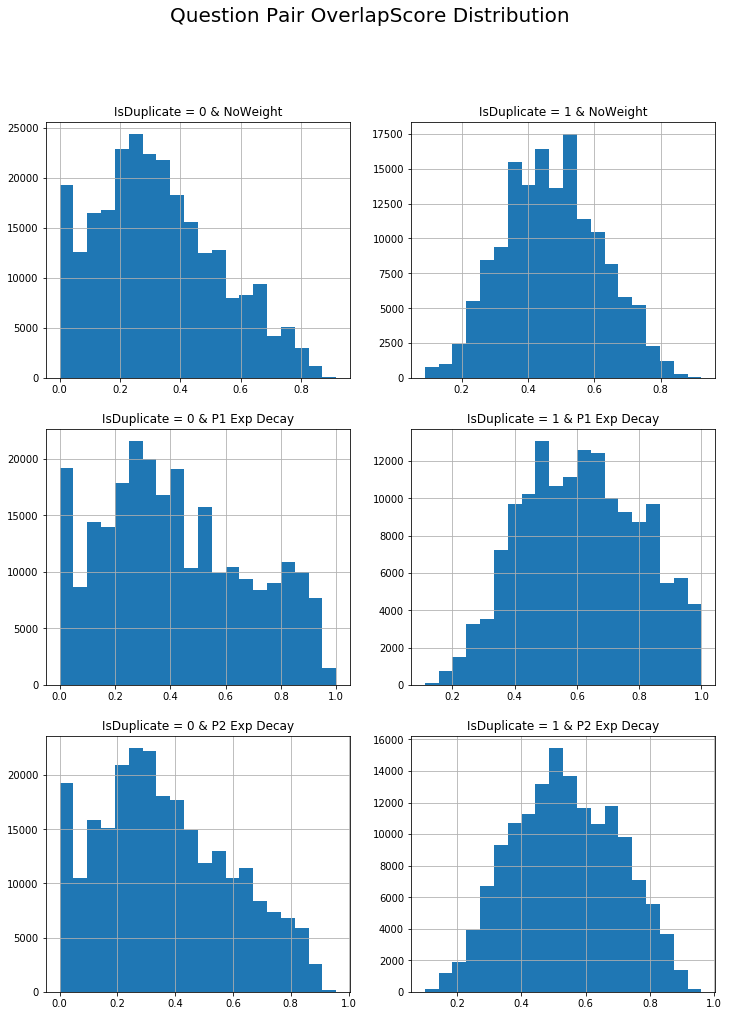

In [0]:
plt.figure(figsize=(12,16))
plt.suptitle("Question Pair OverlapScore Distribution", size=20)
plt.subplot(3,2,1)
plt.title('IsDuplicate = 0 & NoWeight')
train_df[train_df.is_duplicate == 0].scores_pow2.hist(bins=20)
plt.subplot(3,2,2)
plt.title('IsDuplicate = 1 & NoWeight')
train_df[train_df.is_duplicate == 1].scores_pow2.hist(bins=20)
plt.subplot(3,2,3)
plt.title('IsDuplicate = 0 & P1 Exp Decay')
train_df[train_df.is_duplicate == 0].scores_wo_weight.hist(bins=20)
plt.subplot(3,2,4)
plt.title('IsDuplicate = 1 & P1 Exp Decay')
train_df[train_df.is_duplicate == 1].scores_wo_weight.hist(bins=20)
plt.subplot(3,2,5)
plt.title('IsDuplicate = 0 & P2 Exp Decay')
train_df[train_df.is_duplicate == 0].scores_pow1.hist(bins=20)
plt.subplot(3,2,6)
plt.title('IsDuplicate = 1 & P2 Exp Decay')
train_df[train_df.is_duplicate == 1].scores_pow1.hist(bins=20)
plt.show()

In [0]:
x = train_df[train_df.is_duplicate == 0]

In [0]:
x[x.scores_pow2 > 0.8][['q1_tokens','q2_tokens']].head()

,q1_tokens,q2_tokens
89,"[what, is, review, of, next, warrior, proving,...","[what, is, review, of, next, warrior, proving,..."
1176,"[what, are, most, interesting, products, and, ...","[what, are, most, interesting, products, and, ..."
1316,"[which, is, best, destination, for, honeymoon,...","[which, is, best, destination, for, honeymoon,..."
1470,"[how, much, does, ola, mini, cab, earn, on, av...","[how, much, does, ola, mini, cab, earn, on, av..."
1608,"[what, are, some, things, new, employees, shou...","[what, are, some, things, new, employees, shou..."


### 4 .Creating Vocabulary and WordEmbedding

In [0]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))        
    return embeddings_index

In [0]:
import os
import urllib.request
urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.840B.300d.zip', 'glove840B.zip')

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('glove840B.zip', 'r')
zip_ref.extractall('embeddings')
zip_ref.close()

In [0]:
glove = './embeddings/glove.840B.300d.txt'